Ex2 - Deep learning 

Yuval Dagan, 205785215

Itay Hassid, 209127596


In [ ]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp',
                                    dest_path='./data/mnist.zip',
                                    unzip=True)


Unzipping...Done.


In [ ]:
!wget "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
!wget "http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"

--2021-04-25 16:02:13--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt’

pairsDevTrain.txt   100%[===================>]  55.25K   145KB/s    in 0.4s    

2021-04-25 16:02:14 (145 KB/s) - ‘pairsDevTrain.txt’ saved [56579/56579]

--2021-04-25 16:02:14--  http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26002 (25K) [text/plain]
Saving to: ‘pairsDevTest.txt’

pairsDevTest.txt    100%[===================>]  25.39K   131KB/s    in 0.2s    

2021-04-25 16:02:15 (131 KB/s) - ‘pairsDevTest.txt’ saved [26002/2

In [ ]:
trainFile = 'pairsDevTrain.txt'
testFile = 'pairsDevTest.txt'

# load data: positive and negative examples of the train/test file
def getData(file):
    posPairs = []
    negPairs = []
    for line in f.readlines()[1:]:
        line = line.strip().split('\t')
        if len(line) == 3:
            posPairs.append((line[0], int(line[1]), int(line[2])))
        if len(line) == 4:
            negPairs.append((line[0], int(line[1]), line[2], int(line[3])))
    return posPairs, negPairs

with open(trainFile) as f:
    trainPosPairs, trainNegPairs = getData(f)

with open(testFile) as f:
    testPosPairs, testNegPairs = getData(f)

print(f'Train Positive Pairs: {str(len(trainPosPairs))}, example: {trainPosPairs[0]}')
print(f'Train Negative Pairs: {str(len(trainNegPairs))}, example: {trainNegPairs[0]}')
print(f'Test Positive Pairs: {str(len(testPosPairs))}, example: {testPosPairs[0]}')
print(f'Train Negative Pairs: {str(len(testNegPairs))}, example: {testNegPairs[0]}')

Train Positive Pairs: 1100, example: ('Aaron_Peirsol', 1, 2)
Train Negative Pairs: 1100, example: ('AJ_Cook', 1, 'Marsha_Thomason', 1)
Test Positive Pairs: 500, example: ('Abdullah_Gul', 13, 14)
Train Negative Pairs: 500, example: ('AJ_Lamas', 1, 'Zach_Safrin', 1)


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

baseFolder = './data/lfw2/lfw2/'

# Input: positive and negative examples of trainset or testset
# Output: return a Tensor that contains all examples, and a numpy array of their labels 
# Tensor dims: (num_of_examples, 2, 250, 250, 1), numpy arr dims: (num_of_examples)
# posPairs: tuple(personName, firstImage, secondImage)
# negPairs: tuple(firstPersonName, firstImage, secondPersonName, secondImage)
def loadExamples(trainPosPairs, trainNegPairs):
    dataset = []
    labels = np.ones(len(trainPosPairs))
    for ex in trainPosPairs:
        path = baseFolder+ex[0]
        f1 = '{path}/{name}_{idx:04}.jpg'.format(path=path, name=ex[0], idx=ex[1])
        f2 = '{path}/{name}_{idx:04}.jpg'.format(path=path, name=ex[0], idx=ex[2])
        img1 = tf.keras.preprocessing.image.load_img(f1, color_mode="grayscale")
        img2 = tf.keras.preprocessing.image.load_img(f2, color_mode="grayscale")
        
        img1 = tf.keras.preprocessing.image.img_to_array(img1)/255
        img2 = tf.keras.preprocessing.image.img_to_array(img2)/255
        dataset.append(tf.convert_to_tensor(np.array([img1, img2])))
    
    labels = np.concatenate((labels,np.zeros(len(trainNegPairs))))
    # show = True
    for ex in trainNegPairs:
        path = baseFolder+ex[0]
        f1 = '{path}/{name}_{idx:04}.jpg'.format(path=path, name=ex[0], idx=ex[1])
        img1 = tf.keras.preprocessing.image.load_img(f1, color_mode="grayscale")
        path = baseFolder+ex[2]
        f2 = '{path}/{name}_{idx:04}.jpg'.format(path=path, name=ex[2], idx=ex[3])
        img2 = tf.keras.preprocessing.image.load_img(f2, color_mode="grayscale")
        
        img1 = tf.keras.preprocessing.image.img_to_array(img1)/255
        img2 = tf.keras.preprocessing.image.img_to_array(img2)/255
        dataset.append(tf.convert_to_tensor(np.array([img1, img2])))
    return dataset, labels
    
trainSet, trainLabels = loadExamples(trainPosPairs, trainNegPairs)
testSet, testLabels = loadExamples(testPosPairs, testNegPairs)

In [ ]:
# Split the trainset into train and validation, in a ratio of 80:20
def split_train_validation(x_train, y_train):
    train_size = x_train.shape[0]
    indices = np.random.permutation(train_size)

    x_train, y_train = x_train[indices], y_train[indices]

    x_train, x_validation = x_train[:int(train_size * 0.8)], x_train[int(train_size * 0.8):]
    y_train, y_validation = y_train[:int(train_size * 0.8)], y_train[int(train_size * 0.8):]

    return x_train, x_validation, y_train, y_validation

In [ ]:
# Split the training set and print the new dimensions

trainSet, validationSet, trainLabels, validationLabels = split_train_validation(np.asarray(trainSet), trainLabels)

print(trainSet.shape)
print(validationSet.shape)
print(trainLabels.shape)
print(validationLabels.shape)

(1760, 2, 250, 250, 1)
(440, 2, 250, 250, 1)
(1760,)
(440,)


In [ ]:
# convert the multi-dim numpy array into tensor object

trainTensor = tf.convert_to_tensor(trainSet)
validationTensor =  tf.convert_to_tensor(validationSet)
testTensor = tf.convert_to_tensor(testSet)

# Change first 2 dims so the 2 images will be the first
# and number of examples would be second

trainTensor = tf.transpose(trainTensor, perm=[1,0,2,3,4])
validationTensor = tf.transpose(validationTensor, perm=[1,0,2,3,4])
testTensor = tf.transpose(testTensor, perm=[1,0,2,3,4])

print(f'train shape: {trainTensor.shape}')
print(f'validation shape: {validationTensor.shape}')
print(f'test shape:{testTensor.shape}')

train shape: (2, 1760, 250, 250, 1)
validation shape: (2, 440, 250, 250, 1)
test shape:(2, 1000, 250, 250, 1)


In [ ]:

# Shuffle the train
def shuffleTrain(x_train, y_train):
  indices = tf.range(x_train.shape[0])
  shuffled_indices = tf.random.shuffle(indices)

  trainTnsr = tf.convert_to_tensor(x_train)  
  shuffled_x = tf.gather(trainTnsr, shuffled_indices)
  shuffled_y = tf.gather(y_train, shuffled_indices)

  trainTensor = tf.convert_to_tensor(shuffled_x)

  return trainTensor, shuffled_y

# print('After shuffling:')
# print('x:')
# print(shuffled_x)
# print('y:')
# print(shuffled_y)

In [ ]:
# trainTensor.shape
# trainTensor, trainLabels = shuffleTrain(trainSet, trainLabels)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, MaxPooling2D, Lambda, BatchNormalization, Dropout, Layer, Add, Activation
from tensorflow.keras import Model, Sequential, initializers
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:

# Return the Siamese-Net. all layer, lr, batch size, optimizers, etc configured here
def get_model():
    input_shape = (250, 250,1)

    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    
    # Conv (7x7), 64 filters -> maxpool -> batchnorm -> conv1d, 64 filters
    model.add(Conv2D(64, (7,7), strides=2, activation='relu', input_shape=input_shape, kernel_regularizer=l2(5e-4),
                   kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
                   bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Conv1D(64,1, activation='relu'))

    # conv (3x3), 192
    model.add(Conv2D(192, (3,3),activation='relu', strides=1, input_shape=input_shape, kernel_regularizer=l2(5e-4),
                   kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
                   bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())
    model.add(Conv1D(192,1, activation='relu'))

    # conv (3x3), 384
    model.add(Conv2D(384, (3,3), strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=l2(5e-4),
                   kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
                   bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D())
    # model.add(Dropout(0.3))
    model.add(Conv1D(384,1, activation='relu'))

    # conv (3x3), 256
    model.add(Conv2D(256, (3,3), strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=l2(5e-4),
                   kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
                   bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
    model.add(Conv1D(256,1, activation='relu'))    
    model.add(MaxPooling2D())
    # model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Flatten())
    # model.add(Dropout(0.3))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=l2(5e-3),
                    kernel_initializer=initializers.RandomNormal(stddev=0.02, mean=0), 
                    bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
    

    encoded_l = model(left_input)
    encoded_r = model(right_input)

    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    prediction = Dense(1,activation='sigmoid',bias_initializer=initializers.RandomNormal(stddev=0.01, mean=0.5))(L1_distance)
    # prediction = Dense(1,activation='sigmoid')(L1_distance)

    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=3e-4,
        decay_steps=1000,
        decay_rate=0.99)
    optimizer = Adam(learning_rate=lr_schedule)
                                    
    siamese_net.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy'])

    print(model.summary())
    print(siamese_net.summary())
    
    return siamese_net

In [ ]:
# Print the model layers and parameters

# from keras.utils.vis_utils import plot_model
siamese_net = get_model()
# plot_model(siamese_net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 122, 122, 64)      3200      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 61, 61, 64)        4160      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 59, 59, 192)       110784    
_________________________________________________________________
batch_normalization_12 (Batc (None, 59, 59, 192)      

# Failed try with residual layers

In [ ]:
# # class Residual(Layer):
# #     def __init__(self, channels_in,kernel,**kwargs):
# #         super(Residual, self).__init__(**kwargs)
# #         self.channels_in = channels_in
# #         self.kernel = kernel

# #         self.firstConv = Conv2D( self.channels_in,
# #                                 self.kernel,
# #                                 padding="same",
# #                                 activation='relu')
# #         self.bn1 = BatchNormalization()

# #         self.secondConv = Conv2D( self.channels_in,
# #                                 self.kernel,
# #                                 padding="same")
# #         self.bn2 = BatchNormalization()

# #     def call(self, x):
# #         # the residual block using Keras functional API
# #         first_layer =   Activation("linear", trainable=False)(x)
# #         x =             self.firstConv(x)
# #         # x =             self.bn1(x)
        
# #         x =             self.secondConv(x)
# #         # x =             self.bn2(x)
# #         residual =      Add()([x, first_layer])
# #         x =             Activation("relu")(residual)
# #         return x

# #     def compute_output_shape(self, input_shape):
# #         return input_shape

# def get_model():
#     input_shape = (250, 250,1)

#     left_input = Input(input_shape)
#     right_input = Input(input_shape)

#     #Convolutional Neural Network
#     model = Sequential()
    
#     model.add(Conv2D(64, (7,7), strides=2, activation='relu', input_shape=input_shape, kernel_regularizer=l2(5e-2),
#                    kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
#                    bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
    
#     # model.add(Conv1D(192,1, activation='relu'))

#     model.add(Residual(64, (5, 5)))
#     model.add(MaxPooling2D())
#     # model.add(BatchNormalization())

#     model.add(Residual(64, (3,3)))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())
    
#     model.add(Conv1D(64,1, activation='relu'))

#     model.add(Residual(64, (3,3)))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())

#     model.add(Residual(64, (3,3)))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())
#     model.add(Conv1D(64,1, activation='relu'))
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))

#     model.add(Conv1D(64,1, activation='relu'))
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())
#     model.add(Conv2D(96, (3,3), strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=l2(5e-2),
#                    kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
#                    bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D())
#     model.add(MaxPooling2D())
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
    
#     model.add(Conv2D(128, (3,3), strides=1, activation='relu', input_shape=input_shape, #kernel_regularizer=l2(5e-4),
#                    kernel_initializer=initializers.RandomNormal(stddev=0.01, mean=0), 
#                    bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D())
#     model.add(Dropout(0.2))

#     model.add(Flatten())
#      model.add(Dropout(0.2))
#     model.add(Dense(512, activation='sigmoid', #kernel_regularizer=l2(1e-3),
#                     kernel_initializer=initializers.RandomNormal(stddev=0.02, mean=0), 
#                     bias_initializer = initializers.RandomNormal(stddev=0.01, mean=0.5)))


#     encoded_l = model(left_input)
#     encoded_r = model(right_input)

#     L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#     L1_distance = L1_layer([encoded_l, encoded_r])

#     # prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
#     prediction = Dense(1,activation='sigmoid')(L1_distance)

#     siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

#     lr_schedule = ExponentialDecay(
#         initial_learning_rate=3e-4,
#         decay_steps=1000,
#         decay_rate=0.99)
#     optimizer = Adam(learning_rate=lr_schedule)
                                    
#     siamese_net.compile(optimizer=optimizer,loss="binary_crossentropy", metrics=['accuracy'])

#     print(model.summary())
#     print(siamese_net.summary())
    
#     return siamese_net

In [ ]:
# siamese_net = get_model()

# Train

In [ ]:
from datetime import datetime
import gc

# Metrics
trainLoss = []
trainAccuracy = []
valLoss = []
valAccuracy = []

# Stopping criteria
bestLoss = 1000
lastEpochWithChange = 0
bestWeights = siamese_net.get_weights()

# Timing
start = datetime.now()

epochs = 55
evaluate_every = 1

for i in range(epochs):
    
    print("epoch {0}:".format(i+1))
    trainTensor, targets = shuffleTrain(trainSet, trainLabels)
    pairs = [trainTensor[:,0,:,:,:],trainTensor[:,1,:,:,:]]
    
    # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=5e-3)
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
    loss = siamese_net.fit(pairs, targets, batch_size=64, epochs=1)
    trainLoss.append(loss.history['loss'])
    trainAccuracy.append(loss.history['accuracy'])

    if i % evaluate_every == 0:
        valPair = [validationTensor[0], validationTensor[1]]
        loss = siamese_net.evaluate(valPair, validationLabels)
        valLoss.append(loss[0])
        valAccuracy.append(loss[1])

        # save best loss and model
        if loss[0] < bestLoss:
            bestLoss = loss[0]
            lastEpochWithChange = i
            bestWeights = siamese_net.get_weights()

        # stop if there's no change
        if i - lastEpochWithChange > 7:
            break

    gc.collect()
    print('\n')
        # print("Validation Loss: {0}".format(loss)) 

elapsed = datetime.now() - start
print('Time elapsed (hh:mm:ss.ms) {}'.format(elapsed))    
siamese_net.set_weights(bestWeights)

epoch 1:
14/14 [==============================] - 2s 98ms/step - loss: 9.1489 - accuracy: 0.5295


epoch 2:
14/14 [==============================] - 1s 98ms/step - loss: 6.2477 - accuracy: 0.5295


epoch 3:
14/14 [==============================] - 1s 99ms/step - loss: 4.5018 - accuracy: 0.5295


epoch 4:
14/14 [==============================] - 1s 99ms/step - loss: 3.3886 - accuracy: 0.5341


epoch 5:
14/14 [==============================] - 1s 98ms/step - loss: 2.6493 - accuracy: 0.5705


epoch 6:
14/14 [==============================] - 1s 99ms/step - loss: 2.1554 - accuracy: 0.6091


epoch 7:
14/14 [==============================] - 1s 98ms/step - loss: 1.8026 - accuracy: 0.6409


epoch 8:
14/14 [==============================] - 1s 97ms/step - loss: 1.5767 - accuracy: 0.6227


epoch 9:
14/14 [==============================] - 1s 97ms/step - loss: 1.3811 - accuracy: 0.6341


epoch 10:
14/14 [==============================] - 1s 98ms/step - loss: 1.2502 - accuracy: 0.6500


epoch 11:

In [ ]:
# running test on the test set
testPair = [testTensor[0], testTensor[1]]
loss = siamese_net.evaluate(testPair, testLabels)
print('loss: ' + str(loss[0]))
print('accuracy: ' + str(loss[1]))

32/32 [==============================] - 3s 99ms/step - loss: 0.7351 - accuracy: 0.7060
loss: 0.7350981831550598
accuracy: 0.7059999704360962


In [ ]:
import matplotlib.pyplot as plt

def plot(costs, costsIdx=None, legends=None):
    if costsIdx == None:
        costsIdx = range(1, len(costs[0]) + 1)
    
    for cost in costs:
        plt.plot(costsIdx, cost)
    
    if legends!=None:
        plt.legend(legends)

    plt.show()


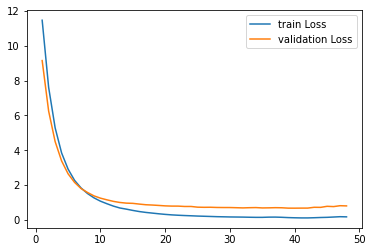

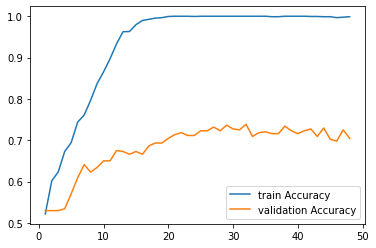

In [ ]:
plot([trainLoss, valLoss], costsIdx=None, legends=['train Loss', 'validation Loss'])
plot([trainAccuracy, valAccuracy], costsIdx=None, legends=['train Accuracy', 'validation Accuracy'])

In [ ]:
# extract correct and incorrect samples
testPair = [testTensor[0], testTensor[1]]
predictions = siamese_net.predict(testPair)

# get predictions, correct: bool array of True/False
preds = np.where((predictions>0.5),1 , 0)
preds = np.squeeze(preds)
correct = np.squeeze(preds) == testLabels

# true_idx has indices of test where the model was right
# false_idx has indices of test where the model was wrong
true_idx = np.where(correct == True)[0]
false_idx = np.where(correct == False)[0]

# choosing a pic where the model wrong
chosen_idx = false_idx[5]
testLabels[chosen_idx]
preds[chosen_idx]
testPosPairs[chosen_idx]

# Take the pair of images
img1 = testTensor[0,chosen_idx,:,:,0].numpy()
img2 = testTensor[1,chosen_idx,:,:,0].numpy()

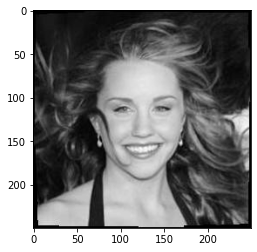

In [ ]:
plt.imshow(img1*255,cmap='gray')

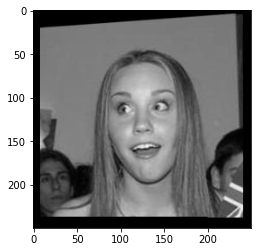

In [ ]:
plt.imshow(img2*255,cmap='gray')